In [1]:
import dynamiqs as dq
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [7]:
#parameters
pi=jnp.pi
N=20 #Hilbert space dimension
n=2 #number Fock state
alpha=1 #coherent state amplitude
g2=1.0
k_b=10
e_d=-4

T      = 4.0      # total time
n_steps = 80      # number frame
tlist  = jnp.linspace(0, T, n_steps)

def cat_factory(n):
    cat_n = dq.coherent(N, alpha)
    for i in range(1,n):
        cat_n += dq.coherent(N, np.exp(1j*2*i*np.pi/n)*alpha)

    
    return cat_n / cat_n.norm()

def cat_dm_factory(n):
    cat_n = dq.coherent(N, alpha)
    for i in range(1,n):
        cat_n += dq.coherent(N, np.exp(1j*2*i*np.pi/n)*alpha)

    
    return (cat_n / cat_n.norm()).todm()


In [147]:
#operators and states
a=dq.destroy(N)
# I  = dq.eye(N)
# a_sys  = dq.tensor(a,  I)
# adag_sys = a_sys.dag()
# b_sys  = dq.tensor(I,  a)
# bdag_sys = b_sys.dag()

D = lambda alph: dq.expm(alph*a.dag() - alph.conjugate()*a)
P = dq.expm(1j*pi*a.dag()@a)

W_fromDP = lambda alph, rho: (2 / pi * dq.trace(D(alph) @ P @ D(alph).dag() @ rho)).item().real

meas_prob = lambda alph: 1/2 * (1 + pi/2 * W_fromDP(alph))

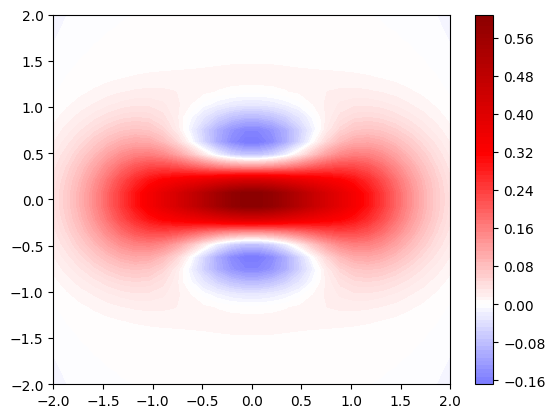

In [119]:
# some_state = dq.fock_dm(N, 1)
# some_state = dq.coherent_dm(N, 1) + dq.coherent_dm(N, -1)
some_state = cat_dm_factory(2)

nx, ny = 30, 30
xrange = (-2, 2)
yrange = (-2, 2)

xvals = np.linspace(xrange[0], xrange[1], nx)
yvals = np.linspace(yrange[0], yrange[1], ny)

wigner_values = np.zeros((nx,ny))

# xx, yy = np.meshgrid(xvals, yvals)

for xi, yi in np.ndindex((nx,ny)):
    xv, yv = xvals[xi], yvals[yi]
    wigner_values[xi, yi] = W_fromDP(xv+yv*1j, some_state)

plt.contourf(xvals, yvals, wigner_values.T, levels=100, cmap="seismic", vmin=-2/np.pi, vmax=2/np.pi)
plt.colorbar()


In [1]:
with open("../../data/synthetic/noisy_wigner_1.pickle", 'rb') as f:
    my_noisy_wigner = pickle.load(f)

# xvec, yvec, wigner = my_noisy_wigner
xvec, yvec, wigner = dq.wigner(dq.fock(N, 1))
xvec, yvec, wigner = dq.wigner(cat_dm_factory(2))

def find_nearest(array, value):
    # array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx].item(), idx

alpha_k = (1,5.01)
alpha_z = alpha_k[0] + 1j* alpha_k[1]

xval, xi = find_nearest(xvec, alpha_k[0])
yval, yi = find_nearest(yvec, alpha_k[1])

meas_prob = 1/2 * (1 + pi/2 * wigner[xi, yi])

E = 1/2 * (dq.eye(N) + D(alpha_z) @ P @ D(alpha_z).dag())


# test_rho = dq.fock_dm(N, 1)
test_rho = cat_dm_factory(2)

pred_prob = dq.trace(E @ test_rho)

print(pred_prob, meas_prob)


NameError: name 'pickle' is not defined

In [ ]:
def get_measurement_probabilities(xvec, yvec, wigner, alpha_ks):
    w_ks = []
    for alpha_k in alpha_ks:
        xi = np.abs(xvec - alpha_k[0]).argmin()
        yi = np.abs(yvec - alpha_k[1]).argmin()
        w_ks += [1/2 * (1 + jnp.pi/2 * wigner[xi, yi])]
    
    return w_ks

def get_measurement_operators(N, alpha_ks):
    Eks = []
    for alpha_k in alpha_ks:
        alpha_z = alpha_k[0] + 1j* alpha_k[1]
        a=dq.destroy(N)
        D = lambda alph: dq.expm(alph*a.dag() - alph.conjugate()*a)
        P = dq.expm(1j*jnp.pi*a.dag()@a)
        E = 1/2 * (dq.eye(N) + D(alpha_z) @ P @ D(alpha_z).dag())
        Eks += [E]
    
    return Eks



       
N = 20
xvec, yvec, wigner = dq.wigner(dq.fock(N, 1))
alpha_ks = [(1,1), (1,-1), (-1,-1), (-1,1)]

wks = get_measurement_probabilities(xvec, yvec, wigner, alpha_ks)
Eks = get_measurement_operators(N, alpha_ks)

/home/manman/.local/lib/python3.10/site-packages/equinox/_module.py:1041: UserWarning: A `SparseDIAQArray` has been converted to a `DenseQArray` while computing its matrix exponential.
  return self.__func__(self.__self__, *args, **kwargs)
/tmp/ipykernel_181135/4174245757.py:17: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  E = 1/2 * (dq.eye(N) + D(alpha_z) @ P @ D(alpha_z).dag())


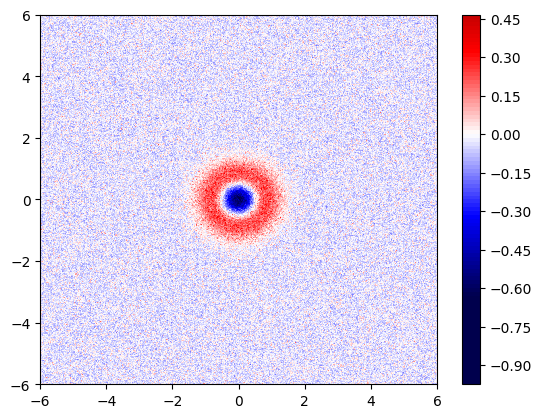

In [131]:
plt.contourf(xvec, yvec, wigner, levels=100, cmap="seismic", vmin=-2/np.pi, vmax=2/np.pi)
plt.colorbar()

In [14]:
rho1 = dq.fock_dm(N, 1)
rho2 = 0.8 * dq.fock_dm(N, 1) + 0.2 * dq.fock_dm(N, 0)
rho2 /= rho2.norm()

# xvec, yvec, wigner = dq.wigner(rho2)

# plt.contourf(xvec, yvec, wigner, levels=100, cmap="seismic", vmin=-2/np.pi, vmax=2/np.pi)
# plt.colorbar()

fidelity = dq.fidelity(rho1, rho2)


In [16]:
Eks[0]

QArray: shape=(20, 20), dims=(20,), dtype=complex64, layout=dense
[[ 5.09157836e-01+1.00582838e-07j  1.83155853e-02-1.83156654e-02j
   5.96046448e-08-5.18044680e-02j -5.98186776e-02-5.98186627e-02j
  -1.19637318e-01+6.70552254e-08j -1.07006878e-01+1.07006907e-01j
   2.23517418e-08+1.74741492e-01j  1.32092267e-01+1.32092208e-01j
   1.86806157e-01-2.98023224e-08j  1.24538541e-01-1.24538548e-01j
   5.26197255e-08-1.57525122e-01j -9.50012654e-02-9.50013474e-02j
  -1.09660357e-01-6.00703061e-08j -6.08943477e-02+6.08943030e-02j
  -2.51457095e-08+6.48849905e-02j  3.38319913e-02+3.38319838e-02j
   3.29012349e-02+7.50878826e-09j  1.72124356e-02-1.72124468e-02j
   3.15412763e-09-1.30418614e-02j -9.82161518e-03-9.82160866e-03j]
 [ 1.83156561e-02+1.83155946e-02j  5.64104617e-01+2.30967999e-07j
   7.77065530e-02-7.77068734e-02j  4.09781933e-08-1.49546564e-01j
  -1.19637199e-01-1.19637311e-01j -1.60510153e-01+1.00582838e-07j
  -8.73708203e-02+8.73709470e-02j -5.58793545e-08+6.60450459e-02j
   2.3618